In [1]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
import time


from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras import optimizers, applications
from keras.applications import ResNet50
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import load_model

%matplotlib inline
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')

In [2]:
fold = pd.read_csv('../input/5-fold-cross-validation-old-new/5-fold.csv')

In [3]:
validation = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')

In [4]:
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [5]:
fold_0 = fold[['id_code','diagnosis','fold_0']]

In [6]:
train = fold_0[fold_0['fold_0'] == 'train']
valid = fold_0[fold_0['fold_0'] == 'validation']

In [7]:
train.shape, valid.shape

((18697, 3), (733, 3))

In [8]:
batch_size = 20 #número de amostras propagadas pela rede, ou seja com 1000 amostras e um batch_size = 10.
# O algoritmo vai pegar as 10 primeiras amostras do conjunto de treinamento e treinar a rede, em seguida
# ele pega mais 10 amostras até o fim do conjunto.

epochs = 20 #quando um conjunto de dados inteiro é passado para frente e para trás atráves da rede neural


learning_rate = 1e-4 #A quantidade que os pesos são atualizados durante o treinamento,
# se sua taxa de aprendizagem for muito baixa, o treinamento irá progredir muito lentamente, pois estará
# fazendo pequenas atualizações nos pesos da rede. Mas se a taxa de aprendizagem for muito alta, pode
# causa um comportamento divergente em sua função de perda.



height = 224 #dimensão da imagem
width = 224 #dimensão da imagem
canal = 3 #referente ao RGB
num_classes = train['diagnosis'].nunique() #5 = os estágios da RD

In [9]:
valid

,id_code,diagnosis,fold_0
15770,../input/resized-2015-2019-blindness-detection...,1,validation
15772,../input/resized-2015-2019-blindness-detection...,0,validation
15774,../input/resized-2015-2019-blindness-detection...,0,validation
15775,../input/resized-2015-2019-blindness-detection...,2,validation
15781,../input/resized-2015-2019-blindness-detection...,3,validation
...,...,...,...
19400,../input/resized-2015-2019-blindness-detection...,0,validation
19405,../input/resized-2015-2019-blindness-detection...,0,validation
19419,../input/resized-2015-2019-blindness-detection...,0,validation
19423,../input/resized-2015-2019-blindness-detection...,2,validation


In [10]:
train['diagnosis'] = train['diagnosis'].astype(str)

valid['diagnosis'] = valid['diagnosis'].astype(str)

In [11]:
validation['id_code'] = validation['id_code'].apply(lambda x: x + '.png')

In [12]:
validation['diagnosis'] = validation['diagnosis'].astype(str)

In [13]:
test['id_code'] = test['id_code'].apply(lambda x: x + '.png')

In [14]:
#gerar novas imagens
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split = 0.2,
                                   horizontal_flip = True)


#train
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train,
    x_col = 'id_code',
    y_col = 'diagnosis',
    batch_size = batch_size,
    class_mode = 'categorical',
    target_size = (height, width),
    subset = 'training'
)

#validation
valid_generator = train_datagen.flow_from_dataframe(
    dataframe = validation,
    directory='../input/aptos2019-blindness-detection/train_images',
    x_col = 'id_code',
    y_col = 'diagnosis',
    batch_size = batch_size,
    class_mode = 'categorical',
    target_size = (height,width),
    subset = 'validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = '../input/aptos2019-blindness-detection/test_images',
    x_col = 'id_code',
    target_size = (height,width),
    batch_size = 1,
    shuffle = False,
    class_mode = None
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 14958 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.
Total number of batches = 747 and 36


In [15]:
def create_model():
  pretrained_model = EfficientNetB0(input_shape=[width,height, 3], include_top=False, weights='imagenet')
  for layer in pretrained_model.layers:
    pretrained_model.trainable = True
    
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
    
  return model

model = create_model()
model.summary()

16711680/16705208 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [17]:
history = model.fit(train_generator, validation_data=valid_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                     validation_steps=STEP_SIZE_VALID,epochs=15,
                    shuffle=True,
                    use_multiprocessing=True,
                    workers=16,
                    callbacks=[reduce_lr]
                 )

Epoch 1/15
747/747 [==============================] - 296s 378ms/step - loss: 1.2788 - accuracy: 0.4627 - val_loss: 1.4639 - val_accuracy: 0.2653
Epoch 2/15
747/747 [==============================] - 278s 367ms/step - loss: 1.0212 - accuracy: 0.5683 - val_loss: 1.5211 - val_accuracy: 0.4125
Epoch 3/15
747/747 [==============================] - 280s 370ms/step - loss: 0.9294 - accuracy: 0.6062 - val_loss: 1.2058 - val_accuracy: 0.5569
Epoch 4/15
747/747 [==============================] - 272s 359ms/step - loss: 0.8466 - accuracy: 0.6415 - val_loss: 419.2468 - val_accuracy: 0.2847
Epoch 5/15
747/747 [==============================] - 279s 366ms/step - loss: 0.7638 - accuracy: 0.6897 - val_loss: 1.3732 - val_accuracy: 0.3694
Epoch 6/15
747/747 [==============================] - 278s 368ms/step - loss: 0.6900 - accuracy: 0.7195 - val_loss: 1.4075 - val_accuracy: 0.4264
Epoch 7/15
747/747 [==============================] - 276s 364ms/step - loss: 0.5914 - accuracy: 0.7717 - val_loss: 14.291

In [18]:
model.save('efcb0-f0.h5')

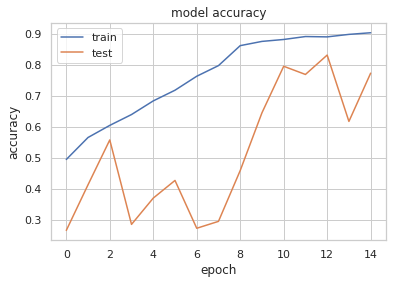

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

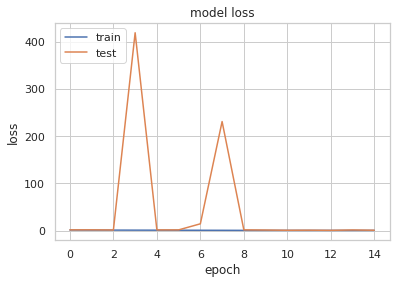

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')